## Functional prediction of hypothetical TFs in bacteria using supervised machine learning: *Pseudomonas aeruginosa*

Created by Emanuel Flores-Bautista 2018.  All code contained in this notebook is licensed under the [Creative Commons License 4.0](https://creativecommons.org/licenses/by/4.0/).

This is the workflow we will use:
    
1. Load in the TF-TF network from RegulonDB as a `DataFrame`, and NetworkX.
2. Apply clustering louvain algorithm to find the modules (caveat: each run the cluster labels change, but the clusters have the same content, i.e. we have to make our predictions in one single run). Add a new attribute in the network corresponding to cluster labels. Validate their functional relationship (e.g. SoxR and SoxS, GadEWX fall into the same modules, respectively)
4. Data preprocessing: check for missing data, normalize, and reduce dimensionality using PCA. 
6. Multi-label classification: Assign the cluster labels to the expression dataframe. 
5. Train a multi-label neural network with the known TF exp data assigning the cluster labels (try first with a SVM). Based on this ref: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f 
6. Validate the performance. We can try 4 different algorithms and then predict with the best one. 
7. Predict the labels for the TFs with unknown physiological function.
8. Analyze results. 
    

In [1]:
pwd

'/Users/manoloflores/jupyter-notebooks'

In [2]:
cd ../Desktop/uni/bioinfo/data/paeru/

/Users/manoloflores/Desktop/uni/bioinfo/data/paeru


In [7]:
##Setting the Pyplot Figures inside the notebook
%matplotlib inline

#Get svg graphics from the Notebook
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random 
import matplotlib as mpl
import community
import csv

sns.set_style('white')
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#mpl.rc('axes', prop_cycle=(cycler('color', ['b','g','y','m','c']) ))
mpl.rc('text', usetex=False)

tw = 1.5
sns.set_style({"xtick.major.size": 6, "ytick.major.size": 6,
               "xtick.minor.size": 4, "ytick.minor.size": 4,
               'axes.labelsize': 28,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=28) 
mpl.rc('ytick', labelsize=28)
mpl.rc('axes', linewidth=1.75)
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 24})

In [18]:
df_trn = pd.read_csv('paeru-trn.csv',  comment= '#')
df_trn.head()

,Regulator,Operon,Target gene,mode of regulation,Experimental Evidence,PubMed Reference,P. aeruginosa Strain
0,agmR,NaN,pqqH,+,"lac-promoter, B-galactosidase assay and RT-PCR",19902179,ATCC
1,algR,NaN,hcnA,-,mutant and PCR,19270096,PAO1
2,anr,cox,coxA,-,Microarray and Gene Chip data analysis,19930444,PAO1
3,anr,cox,coxB,-,Microarray and Gene Chip data analysis,19930444,PAO1
4,anr,cox,colII,-,Microarray and Gene Chip data analysis,19930444,PAO1


In [9]:
tfs_df = pd.read_csv('paeru_tfs.csv')

In [13]:
tf_list = tfs_df['TFs'].values

In [14]:
tf_list[:5]

array(['PA0779', 'PA3697', 'PA5471', 'agmR', 'aguR'], dtype=object)

#### Extracting the TF-TF net

In [15]:
tf_tf_list = []

In [19]:
for row in df_trn['Target gene']:
    if row in tf_list: 
        tf_tf_list.append(1)
    else:
        tf_tf_list.append(0)
        

In [20]:
df_trn['tf'] = tf_tf_list

In [21]:
df_trn.head()

,Regulator,Operon,Target gene,mode of regulation,Experimental Evidence,PubMed Reference,P. aeruginosa Strain,tf
0,agmR,NaN,pqqH,+,"lac-promoter, B-galactosidase assay and RT-PCR",19902179,ATCC,0
1,algR,NaN,hcnA,-,mutant and PCR,19270096,PAO1,0
2,anr,cox,coxA,-,Microarray and Gene Chip data analysis,19930444,PAO1,0
3,anr,cox,coxB,-,Microarray and Gene Chip data analysis,19930444,PAO1,0
4,anr,cox,colII,-,Microarray and Gene Chip data analysis,19930444,PAO1,0


In [22]:
tf_tf_net = df_trn[df_trn['tf'] == 1]

In [23]:
tf_tf_net.shape

(93, 8)

In [24]:
tf_tf_net.head()

,Regulator,Operon,Target gene,mode of regulation,Experimental Evidence,PubMed Reference,P. aeruginosa Strain,tf
20,bexR,NaN,bexR,+,"Microarrays, chip, RT-PCR and lacZ-reporter",20041030,PAO1,1
27,fhpR,NaN,fhpR,-,lacZ-reporter and B-galactosidase assay,19767835,PAO1,1
40,lasR,NaN,tpbA,+,Transcriptome profiling and RT-PCR,19543378,PA14,1
90,mexT,NaN,exsA,-,"RT-PCR, lacZ-reporter and B-galactosidase assay",19683048,PAO1,1
98,PA0779,NaN,fhpR,-,lacZ-reporter and B-galactosidase assay,19767835,PAO1,1


In [25]:
#Pandas DataFrame to a NetworkX graph object
tf_trn = nx.from_pandas_edgelist(df= tf_tf_net, source= 'Regulator', target='Target gene',
                             edge_attr='mode of regulation')

In [26]:
#Calculating eigenvector centrality to get the hubs
eigen_cen= nx.eigenvector_centrality(tf_trn)
hubs= sorted(eigen_cen.items(), key= lambda cc: cc[1], reverse= True)[:10]
hubs

[('rhlR', 0.5160165927773019),
 ('lasR', 0.5123180985978882),
 ('vfr', 0.34796505775838366),
 ('mvfR', 0.28813789014281227),
 ('algQ', 0.22507289775529424),
 ('ampR', 0.22507289775529424),
 ('tpbA', 0.15745834770732636),
 ('rpoN', 0.13009940360986172),
 ('mexR', 0.12683366531740034),
 ('rsaL', 0.11777357530685671)]

In [29]:
#Extracting the LCC
tf_tf_lcc = max(nx.connected_component_subgraphs(tf_trn), key=len)


In [30]:
communities_trn = community.best_partition(tf_tf_lcc)

In [31]:
#How many clusters do we get from the TF-TF LCC? 

print(max(communities_trn.values()) +1 )

8


In [32]:
nx.set_node_attributes(tf_tf_lcc, values= communities_trn, name='modularity')

In [33]:
cluster1 =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 0]

cluster2 =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 1]

cluster3 =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 2]

cluster4 =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 3]

cluster5 =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 4]

cluster6 =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 5]

cluster7 =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 6]

cluster8  =  [n for n in tf_tf_lcc.nodes() if tf_tf_lcc.node[n]['modularity'] == 7]

In [34]:
cluster1

['fur', 'gbuR', 'pchR', 'pfeR', 'agmR', 'glpR']

In [35]:
cluster2

['anr', 'dnr', 'narL']

Now that we have our clusters of TFs, let's proceed to preprocess the expression data. 

### Expression data pre-processing

In [36]:
df_x = pd.read_csv("colombos_paeru_exprdata_20151029.txt", delimiter= '\t', comment= '#')
df_x.head()

,locustag,gene name,Reference description,ref_GSE4026_WT_OD0.5,ref_GSE4026_WT_OD0.5.1,ref_GSE4026_WT_OD0.5.2,ref_GSE4026_WT_OD0.5.3,ref_GSE4026_WT_OD0.5.4,ref_GSE4026_WT_OD0.5.5,ref_GSE4026_WT_OD0.5.6,...,ref_GSE58862_WT,ref_GSE58862_WT.1,ref_GSE58862_WT.2,ref_GSE58862_WT.3,ref_GSE58862_WT.4,ref_GSE58862_WT.5,ref_GSE58862_WT.6,ref_GSE58862_WT.7,ref_GSE58862_WT.8,ref_GSE58862_WT.9
0,PA4372,PA4372,4374,0.39906,-0.27788,-0.55782,-0.298950,0.25207,0.30557,0.015565,...,-0.416470,-0.42538,-0.171690,-0.553160,-0.508280,-0.501250,-0.476490,-0.533060,-0.385570,-0.510890
1,PA4373,PA4373,4375,-0.17034,-0.47932,-0.37914,-1.141500,-0.65243,0.25024,0.211010,...,-0.470950,-0.35411,-0.186720,-0.451170,-0.510100,-0.441120,-0.355190,-0.346370,-0.291120,-0.413110
2,PA4374,PA4374,4376,-0.67948,-0.24802,0.15095,0.235100,0.79640,-0.80024,-0.279800,...,0.062909,0.12707,0.046114,-0.000962,0.074838,0.040787,0.098608,-0.019972,0.000630,0.047984
3,PA4375,PA4375,4377,-0.87518,-0.25627,0.81047,0.892840,0.88056,-0.89583,-0.160360,...,0.073901,0.19379,0.058365,0.110420,0.119340,0.055979,0.094709,0.076326,0.041963,0.192550
4,PA4376,pncB2,4378,-0.10441,-0.49771,-0.49071,-0.072914,-0.22118,0.38368,-0.838580,...,0.040202,0.17626,0.035601,0.107870,0.020122,-0.003838,0.098458,0.064412,0.040828,0.187640


In [37]:
df_x.shape

(4429, 562)

In [38]:
def test_missing_data(df, fname):
    """Look for missing entries."""
    assert np.all(df.notnull()), fname + ' contains missing data'

In [39]:
fname = 'colombos_paeru_exprdata_20151029.txt'

In [40]:
test_missing_data(df_x, fname)

AssertionError: colombos_paeru_exprdata_20151029.txt contains missing data

In [41]:
##Replacing the NaNs with the median of each column (expression condition)
df_x = df_x.fillna(df_x.median())

In [42]:
test_missing_data(df_x, fname)

We're good to go. 

####  Dividing the expression and annotation datasets

In [44]:
annot= df_x.iloc[:,:3]
exp = df_x.iloc[:,3:]

In [45]:
annot.head()

,locustag,gene name,Reference description
0,PA4372,PA4372,4374
1,PA4373,PA4373,4375
2,PA4374,PA4374,4376
3,PA4375,PA4375,4377
4,PA4376,pncB2,4378


In [46]:
from sklearn.preprocessing import StandardScaler as st
std_scaler = st() # initialize stdScaler object
df_ex = std_scaler.fit_transform(exp)  # transform data
df_ex= pd.DataFrame(df_ex)  #go from std scaler object to df

In [47]:
df_ex.describe()## check if mean = 0 , s.d. = 1 

,0,1,2,3,4,5,6,7,8,9,...,549,550,551,552,553,554,555,556,557,558
count,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,...,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03,4.429000e+03
mean,4.863023e-17,8.817362e-18,-2.367590e-17,8.979045e-17,-2.121932e-17,-1.170760e-16,1.698423e-16,-1.038782e-16,2.436525e-17,4.334106e-17,...,2.306176e-17,7.800890e-17,-1.504028e-18,-3.158458e-17,1.885048e-17,-1.804833e-17,5.314231e-18,1.223276e-17,1.423813e-17,4.592298e-17
std,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,...,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00
min,-5.444778e+00,-5.402485e+00,-5.175880e+00,-5.738712e+00,-7.796913e+00,-4.816482e+00,-6.040191e+00,-6.599566e+00,-5.761099e+00,-5.464318e+00,...,-1.735807e+01,-1.683504e+01,-1.143493e+01,-6.919876e+00,-6.898993e+00,-8.566631e+00,-1.664414e+01,-6.552998e+00,-7.218859e+00,-1.653566e+01
25%,-5.464152e-01,-5.354005e-01,-5.116261e-01,-4.707079e-01,-4.466736e-01,-5.495407e-01,-5.051940e-01,-5.257671e-01,-4.737837e-01,-4.758205e-01,...,-1.401863e-01,-2.081378e-01,-5.835356e-01,-4.455856e-01,-3.864561e-01,-2.756227e-01,-1.789979e-01,-4.265152e-01,-4.388975e-01,-2.143702e-01
50%,-1.506575e-01,-1.576834e-01,-1.813372e-01,-1.658139e-01,-5.037828e-02,-1.536203e-01,-1.413588e-01,-1.568060e-01,-1.696845e-01,-9.344114e-02,...,8.138446e-02,5.073202e-02,-9.720670e-03,-9.252155e-02,-1.003026e-01,-6.418285e-02,6.412598e-02,-7.475554e-02,-5.028284e-02,4.370861e-02
75%,3.657911e-01,3.390271e-01,2.900729e-01,2.170175e-01,3.526403e-01,3.772787e-01,3.187507e-01,3.482203e-01,2.236671e-01,3.457832e-01,...,2.863057e-01,3.187308e-01,5.695573e-01,2.902662e-01,2.125584e-01,1.466850e-01,3.100478e-01,2.907780e-01,3.594328e-01,3.209232e-01
max,7.367306e+00,7.059914e+00,6.674187e+00,1.082831e+01,9.136374e+00,6.242306e+00,7.127717e+00,6.508462e+00,9.569231e+00,1.085524e+01,...,1.137373e+01,1.302729e+01,6.264489e+00,1.023223e+01,1.065201e+01,1.510992e+01,1.214637e+01,8.938069e+00,8.472909e+00,1.188193e+01


In [62]:
df_exp = df_ex

In [64]:
df_exp.shape

(4429, 559)

In [49]:
df_trn.tail()

,Regulator,Operon,Target gene,mode of regulation,Experimental Evidence,PubMed Reference,P. aeruginosa Strain,tf
1015,vfr,NaN,vfr,+,Prodoric,18974177,PAO1,1
1016,vqsM,NaN,pprB,+,Prodoric,18974177,PAO1,1
1017,vqsM,NaN,rpoS,+,Prodoric,18974177,PAO1,0
1018,vqsM,NaN,vqsR,+,Prodoric,18974177,PAO1,1
1019,vqsR,NaN,pprB,-,Prodoric,18974177,PAO1,1


In [50]:
del(df_trn['tf'])

In [51]:
#Renaming the columns for easier data wrangling 

df_trn.columns = ['tf', 'operon', 'tg', 'regtype', 'ev', 'PMID', 'strain']

In [60]:
#Now let's filter the regulons of each TF from the TRN

cluster_1 = df_trn[(df_trn['tf'] =='gbuR') | (df_trn['tf'] =='pfeR')\
                 | (df_trn['tf'] =='pchR') | (df_trn['tf'] =='fur')\
                 | (df_trn['tf'] =='agmR')| (df_trn['tf'] =='glpR')
                  ]

cluster_1_tgs = []

#Making a list that corresponds to the first cluster's target genes (TGs)

for row in cluster_1['tg']:
    cluster_1_tgs.append(row)
    
#Make a set to avoid repetition, and then re-make a list out of it.    
cluster1_tgs = list(set(cluster_1_tgs))
print('Cluster 1 has %d target genes.' %len(cluster1_tgs))

#Now let's filter the regulons of each TF from the TRN

cluster_2 = df_trn[(df_trn['tf'] =='gacA') | (df_trn['tf'] =='qscR')\
                 | (df_trn['tf'] =='ampR') | (df_trn['tf'] =='algQ')\
                 | (df_trn['tf'] =='algR4')| (df_trn['tf'] =='mvfR')\
                 | (df_trn['tf'] =='rhlR') | (df_trn['tf'] =='rsaL')\
                 | (df_trn['tf'] =='ihf')| (df_trn['tf'] =='algR3')\
                 | (df_trn['tf'] =='lasR')
                  ]

cluster_2_tgs = []

#Making a list that corresponds to the second cluster's target genes (TGs)

for row in cluster_2['tg']:
    cluster_2_tgs.append(row)
    
    
#Make a set to avoid repetition, and then re-make a list out of it.
    
cluster2_tgs = list(set(cluster_2_tgs))

#Let's see how many TGs does cluster 2 have 

print('Cluster 2 has %d target genes.'%len(cluster2_tgs))

#Now let's filter the regulons of each TF from the TRN

cluster_3 = df_trn[(df_trn['tf'] =='fleQ') | (df_trn['tf'] =='vfr')\
                 | (df_trn['tf'] =='pvdS') | (df_trn['tf'] =='hu')\
                 | (df_trn['tf'] =='ptxR')| (df_trn['tf'] =='mvtA')\
                 | (df_trn['tf'] =='ptxS') | (df_trn['tf'] =='toxR')\
                 | (df_trn['tf'] =='rpoD')
                  ]

cluster_3_tgs = []

#Making a list that corresponds to the cluster's target genes (TGs)

for row in cluster_3['tg']:
    cluster_3_tgs.append(row)
    
#Make a set to avoid repetition, and then re-make a list out of it.

    
cluster3_tgs = list(set(cluster_3_tgs))

print('Cluster 3 has %d target genes.'%len(cluster3_tgs))

#Now let's filter the regulons of each TF from the TRN

cluster_4 = df_trn[(df_trn['tf'] =='exsA') | (df_trn['tf'] =='mexR')\
                 | (df_trn['tf'] =='mexT') | (df_trn['tf'] =='nalC')\
                 | (df_trn['tf'] =='psrA')| (df_trn['tf'] =='rpoS')\
                 | (df_trn['tf'] =='exsD') 
                  ]
cluster_4_tgs = []

#Making a list that corresponds to the cluster's target genes (TGs)...

for row in cluster_4['tg']:
    cluster_4_tgs.append(row)
    
#Make a set to avoid repetition, and then re-make a list out of it...

    
cluster4_tgs = list(set(cluster_4_tgs))

print('Cluster 4 has %d target genes.'%len(cluster4_tgs))


cluster_5 = df_trn[(df_trn['tf'] =='dnr') | (df_trn['tf'] =='anr')\
                 | (df_trn['tf'] =='narL') ]

cluster_5_tgs = []

for row in cluster_5['tg']:
    cluster_5_tgs.append(row)
    
cluster5_tgs = list(set(cluster_5_tgs))

print('Cluster 5 has %d target genes.'%len(cluster5_tgs))


#Now let's filter the regulons of each TF from the TRN

cluster_6 = df_trn[(df_trn['tf'] =='PA0779') | (df_trn['tf'] =='pilA')\
                 | (df_trn['tf'] =='fhpR') | (df_trn['tf'] =='rpoN')\
                 | (df_trn['tf'] =='pilR')]

cluster_6_tgs = []

for row in cluster_6['tg']:
    cluster_6_tgs.append(row)
    
cluster6_tgs = list(set(cluster_6_tgs))

print('Cluster 6 has %d target genes.'%len(cluster6_tgs))

#Now let's filter the regulons of each TF from the TRN

cluster_7 = df_trn[(df_trn['tf'] =='phoQ') | (df_trn['tf'] =='pmrA')\
                 | (df_trn['tf'] =='phoP') | (df_trn['tf'] =='tbpA')]

cluster_7_tgs = []

for row in cluster_7['tg']:
    cluster_7_tgs.append(row)
    
cluster7_tgs = list(set(cluster_7_tgs))

print('Cluster 7 has %d target genes.'%len(cluster7_tgs))

cluster_8 = df_trn[(df_trn['tf'] =='algR') | (df_trn['tf'] =='algZ')\
                 | (df_trn['tf'] =='algU') | (df_trn['tf'] =='mucB')]

cluster_8_tgs = []

for row in cluster_8['tg']:
    cluster_8_tgs.append(row)
    
cluster8_tgs = list(set(cluster_8_tgs))

print('Cluster 8 has %d target genes.'%len(cluster8_tgs))

Cluster 1 has 88 target genes.
Cluster 2 has 140 target genes.
Cluster 3 has 93 target genes.
Cluster 4 has 81 target genes.
Cluster 5 has 61 target genes.
Cluster 6 has 75 target genes.
Cluster 7 has 55 target genes.
Cluster 8 has 58 target genes.


In [65]:
#Initializing the labels' lists
labels1 = []
labels2 = []
labels3 = []
labels4 = []
labels5 = []
labels6 = []
labels7 = []
labels8 = []

##Seting up the labels for each cluster

#C1
for row in df_x['gene name']:
    if row in cluster1_tgs:
        labels1.append(1)
    else:
        labels1.append(0)

        
#C2        
for row in df_x['gene name']:
    if row in cluster2_tgs:
        labels2.append(1)
    else:
        labels2.append(0)
        
#C3
for row in df_x['gene name']:
    if row in cluster3_tgs:
        labels3.append(1)
    else:
        labels3.append(0)

#C4 
for row in df_x['gene name']:
    if row in cluster4_tgs:
        labels4.append(1)
    else:
        labels4.append(0)
       
        
#C5
for row in df_x['gene name']:
    if row in cluster5_tgs:
        labels5.append(1)
    else:
        labels5.append(0)
        
#C6
for row in df_x['gene name']:
    if row in cluster6_tgs:
        labels6.append(1)
    else:
        labels6.append(0)
        
#C7
for row in df_x['gene name']:
    if row in cluster7_tgs:
        labels7.append(1)
    else:
        labels7.append(0)
        
#C8
for row in df_x['gene name']:
    if row in cluster8_tgs:
        labels8.append(1)
    else:
        labels8.append(0)
        
# Adding the cluster labels for each cluster as extra columns

df_exp['cluster 1'] = labels1
df_exp['cluster 2'] = labels2
df_exp['cluster 3'] = labels3
df_exp['cluster 4'] = labels4
df_exp['cluster 5'] = labels5
df_exp['cluster 6'] = labels6
df_exp['cluster 7'] = labels7
df_exp['cluster 8'] = labels8


In [66]:
#Let's make a list to filter out the TGs in each cluster
#This will allow us to use only the genes that are regulated by TFs
#(i.e. the TGs of the TRN) as training data


TGs_list = []

for row in df_x['gene name']:
    if row in cluster1_tgs:
        TGs_list.append(1)
        
    elif row in cluster2_tgs:
        TGs_list.append(1)
        
    elif row in cluster3_tgs:
        TGs_list.append(1)
        
    elif row in cluster4_tgs:
        TGs_list.append(1)
        
    elif row in cluster5_tgs:
        TGs_list.append(1)
        
    elif row in cluster6_tgs:
        TGs_list.append(1)
        
    elif row in cluster7_tgs:
        TGs_list.append(1)
        
    elif row in cluster8_tgs:
        TGs_list.append(1)
        
    else:
        TGs_list.append(0)        

In [67]:
##Adding the TG list as a column to the expression data

df_exp['TGs'] = TGs_list

In [69]:
##Let's filter out the genes that are regulated by TFs

regulons_df = df_exp[df_exp['TGs'] == 1]
del(regulons_df['TGs'])
#Let's filter out the genes that are not regulated by TFs

non_reg_df  = df_exp[df_exp['TGs'] == 0]
del(non_reg_df['TGs'])

##Making a dataframe called noise, by randomly picking 
##genes that are NOT REGULATED by TFs without replacement

noise = non_reg_df.sample(n =20, replace = False, axis = 0, random_state = 42)

regulons_with_noise = pd.concat([regulons_df, noise]) ## unbiased train/test dataset 

regulons_with_noise.shape ##Let's look at the nrows and ncols

(334, 567)

In [70]:
X_data = regulons_with_noise.iloc[:,:-8]
y_data = regulons_with_noise.iloc[:,-8:]

In [85]:
clus2 = y_data['cluster 2'].values

In [94]:
y_data['cluster 8'].sum()

39

In [86]:
np.sum(clus2)

80

#### Feature selection 

In [183]:
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2, f_classif

In [231]:
X_new = SelectPercentile(f_classif, percentile=80).fit_transform(X_data, clus2)
X_new.shape

(334, 447)

Let's now apply a PCA to our normalized data. 

In [232]:
from sklearn.decomposition import PCA as PCA
# apply dimensionality reduction
pca = PCA(svd_solver='randomized', random_state = 42).fit(X_new)

Text(0.5,1,'PCA Explained Variance ')

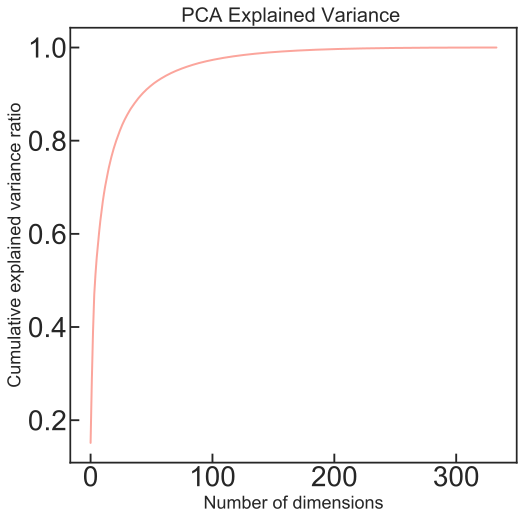

In [233]:
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

# look at it
plt.figure(figsize = (8,6))
plt.plot(cum_exp_var, color = 'salmon', alpha = 0.7)
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance ratio')
#plt.axvline(x= 14 , color='k', linestyle='--')
plt.title('PCA Explained Variance ', fontsize= 20)
#plt.xlim(0,500)
#plt.savefig('PCA-var.tiff',dpi=500, bbox_inches='tight')

In [238]:
vr = np.cumsum(pca.explained_variance_ratio_) 

In [240]:
vr[300]

0.9998738131134555

In [241]:
n_components = 300

In [242]:
X_new = pd.DataFrame(X_new)

In [243]:
##Now let's tranform our data to a PCA object using the original index, so we can track of the genes

df_pca = pca.transform(X_new)

df_pca = pd.DataFrame(df_pca,
                         index= X_new.index)

In [244]:
df_X = df_pca.iloc[:,:n_components] ## We'll keep 420 principal components

In [245]:
##changing the col. names to PC
df_X.columns =  ['PC' +  str(x) for x in range(1, n_components+1)] 

In [246]:
df_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
0,-6.016498,-6.028092,-6.023265,-0.078089,-0.964155,3.204406,4.380231,-0.150129,-3.489661,4.173956,...,-0.003422,-0.035812,0.006579,-0.119632,0.053831,0.099440,-0.007944,0.042326,0.089600,0.083200
1,-1.029625,-6.559403,7.515087,0.793879,-3.884557,-4.942943,0.927705,-3.232631,-3.958598,1.187412,...,-0.070689,0.024794,-0.089221,-0.101512,-0.047230,-0.027211,0.047663,-0.064108,-0.077829,0.191001
2,-2.624554,-8.158411,1.579857,-1.648084,-2.825709,1.039849,-0.819930,-3.274329,2.320870,2.524730,...,-0.035054,-0.005986,-0.061575,-0.160064,0.127938,-0.090961,0.057408,0.031166,-0.041233,0.015614
3,-4.855522,-9.707894,3.916254,-2.127647,-1.968404,-0.697276,0.714014,-1.997033,2.926851,4.601365,...,-0.022754,0.186516,0.187600,0.048113,-0.069179,0.145764,-0.050183,-0.035685,-0.072361,0.002253
4,-6.486713,-9.642923,2.352089,-1.182803,0.148621,-1.775238,1.668411,-3.439658,0.678255,-0.005684,...,0.176999,-0.151550,-0.177990,-0.144009,0.026988,-0.094119,-0.158808,-0.032935,-0.147157,0.028190


In [247]:
df_X.shape

(334, 300)

In [117]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.metrics import categorical_accuracy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score\
,confusion_matrix
from sklearn.model_selection import train_test_split


In [248]:
#The test subset will correspond to 20% of the data at random

X_train, X_test, y_train, y_test = train_test_split(df_X, y_data, test_size=0.2, random_state=42) 

In [249]:
X_train.shape

(267, 300)

In [250]:
y_train.shape

(267, 8)

### Keras classifier

In [279]:
from keras.layers import Dropout
from keras.optimizers import SGD

In [296]:
#softmax activation
model = Sequential()

model.add(Dense(units=500, activation='softmax', input_dim=n_components))
#model.add(Dropout(0.2))
#model.add(Dense(units=50, activation='tanh'))
model.add(Dense(units=8))# 7 cluster classif. output

sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss= 'mse', optimizer='RMSprop', metrics= ['accuracy'])
history = model.fit(X_train, y_train, epochs=80, batch_size= 60)

Epoch 1/80
267/267 [==============================] - 1s 4ms/step - loss: 0.1455 - acc: 0.2397
Epoch 2/80
267/267 [==============================] - 0s 136us/step - loss: 0.1376 - acc: 0.5468
Epoch 3/80
267/267 [==============================] - 0s 160us/step - loss: 0.1327 - acc: 0.6816
Epoch 4/80
267/267 [==============================] - 0s 172us/step - loss: 0.1289 - acc: 0.7940
Epoch 5/80
267/267 [==============================] - 0s 180us/step - loss: 0.1255 - acc: 0.8090
Epoch 6/80
267/267 [==============================] - 0s 185us/step - loss: 0.1225 - acc: 0.8539
Epoch 7/80
267/267 [==============================] - 0s 191us/step - loss: 0.1197 - acc: 0.8689
Epoch 8/80
267/267 [==============================] - 0s 205us/step - loss: 0.1171 - acc: 0.8727
Epoch 9/80
267/267 [==============================] - 0s 179us/step - loss: 0.1146 - acc: 0.8839
Epoch 10/80
267/267 [==============================] - 0s 181us/step - loss: 0.1121 - acc: 0.8839
Epoch 11/80
267/267 [==========

Text(0.5,0,'epochs')

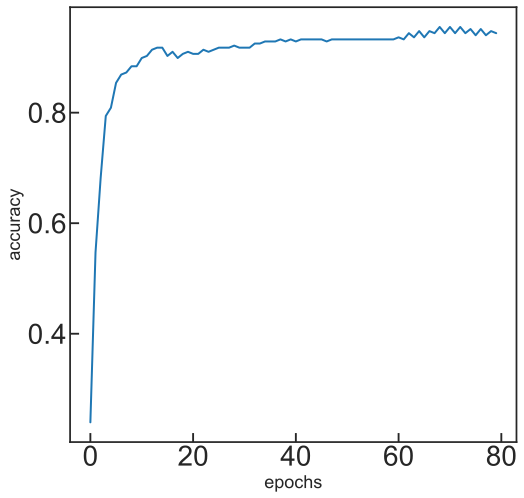

In [297]:
plt.figure(figsize = (8,8))
plt.plot(history.history['acc'])
plt.ylabel('accuracy')
plt.xlabel('epochs')

Epoch 1/80
250/250 [==============================] - 1s 3ms/step - loss: 0.1438 - acc: 0.2440
Epoch 2/80
250/250 [==============================] - 0s 129us/step - loss: 0.1363 - acc: 0.5920
Epoch 3/80
250/250 [==============================] - 0s 131us/step - loss: 0.1319 - acc: 0.7160
Epoch 4/80
250/250 [==============================] - 0s 110us/step - loss: 0.1284 - acc: 0.8080
Epoch 5/80
250/250 [==============================] - 0s 137us/step - loss: 0.1254 - acc: 0.8400
Epoch 6/80
250/250 [==============================] - 0s 140us/step - loss: 0.1225 - acc: 0.8480
Epoch 7/80
250/250 [==============================] - 0s 164us/step - loss: 0.1199 - acc: 0.8800
Epoch 8/80
250/250 [==============================] - 0s 161us/step - loss: 0.1174 - acc: 0.8680
Epoch 9/80
250/250 [==============================] - 0s 164us/step - loss: 0.1151 - acc: 0.8880
Epoch 10/80
250/250 [==============================] - 0s 192us/step - loss: 0.1130 - acc: 0.8920
Epoch 11/80
250/250 [==========

250/250 [==============================] - 0s 163us/step - loss: 0.1223 - acc: 0.7920
Epoch 7/80
250/250 [==============================] - 0s 180us/step - loss: 0.1197 - acc: 0.8320
Epoch 8/80
250/250 [==============================] - 0s 151us/step - loss: 0.1173 - acc: 0.8200
Epoch 9/80
250/250 [==============================] - 0s 121us/step - loss: 0.1151 - acc: 0.8320
Epoch 10/80
250/250 [==============================] - 0s 126us/step - loss: 0.1130 - acc: 0.8320
Epoch 11/80
250/250 [==============================] - 0s 148us/step - loss: 0.1109 - acc: 0.8400
Epoch 12/80
250/250 [==============================] - 0s 174us/step - loss: 0.1090 - acc: 0.8600
Epoch 13/80
250/250 [==============================] - 0s 174us/step - loss: 0.1070 - acc: 0.8520
Epoch 14/80
250/250 [==============================] - 0s 157us/step - loss: 0.1051 - acc: 0.8400
Epoch 15/80
250/250 [==============================] - 0s 174us/step - loss: 0.1033 - acc: 0.8480
Epoch 16/80
250/250 [==============

250/250 [==============================] - 0s 144us/step - loss: 0.1085 - acc: 0.8800
Epoch 13/80
250/250 [==============================] - 0s 159us/step - loss: 0.1064 - acc: 0.8560
Epoch 14/80
250/250 [==============================] - 0s 129us/step - loss: 0.1044 - acc: 0.8640
Epoch 15/80
250/250 [==============================] - 0s 115us/step - loss: 0.1025 - acc: 0.8640
Epoch 16/80
250/250 [==============================] - 0s 132us/step - loss: 0.1007 - acc: 0.8600
Epoch 17/80
250/250 [==============================] - 0s 159us/step - loss: 0.0989 - acc: 0.8560
Epoch 18/80
250/250 [==============================] - 0s 157us/step - loss: 0.0972 - acc: 0.8640
Epoch 19/80
250/250 [==============================] - 0s 174us/step - loss: 0.0954 - acc: 0.8640
Epoch 20/80
250/250 [==============================] - 0s 180us/step - loss: 0.0936 - acc: 0.8680
Epoch 21/80
250/250 [==============================] - 0s 176us/step - loss: 0.0920 - acc: 0.9000
Epoch 22/80
250/250 [===========

250/250 [==============================] - 0s 179us/step - loss: 0.0963 - acc: 0.9080
Epoch 19/80
250/250 [==============================] - 0s 179us/step - loss: 0.0946 - acc: 0.9120
Epoch 20/80
250/250 [==============================] - 0s 165us/step - loss: 0.0928 - acc: 0.9120
Epoch 21/80
250/250 [==============================] - 0s 173us/step - loss: 0.0911 - acc: 0.9160
Epoch 22/80
250/250 [==============================] - 0s 179us/step - loss: 0.0894 - acc: 0.9160
Epoch 23/80
250/250 [==============================] - 0s 179us/step - loss: 0.0877 - acc: 0.9200
Epoch 24/80
250/250 [==============================] - 0s 190us/step - loss: 0.0861 - acc: 0.9200
Epoch 25/80
250/250 [==============================] - 0s 191us/step - loss: 0.0845 - acc: 0.9160
Epoch 26/80
250/250 [==============================] - 0s 195us/step - loss: 0.0829 - acc: 0.9160
Epoch 27/80
250/250 [==============================] - 0s 165us/step - loss: 0.0814 - acc: 0.9160
Epoch 28/80
250/250 [===========

250/250 [==============================] - 0s 164us/step - loss: 0.0865 - acc: 0.9080
Epoch 25/80
250/250 [==============================] - 0s 183us/step - loss: 0.0849 - acc: 0.9160
Epoch 26/80
250/250 [==============================] - 0s 175us/step - loss: 0.0833 - acc: 0.9160
Epoch 27/80
250/250 [==============================] - 0s 172us/step - loss: 0.0818 - acc: 0.9160
Epoch 28/80
250/250 [==============================] - 0s 194us/step - loss: 0.0803 - acc: 0.9320
Epoch 29/80
250/250 [==============================] - 0s 181us/step - loss: 0.0788 - acc: 0.9320
Epoch 30/80
250/250 [==============================] - 0s 193us/step - loss: 0.0774 - acc: 0.9320
Epoch 31/80
250/250 [==============================] - 0s 195us/step - loss: 0.0760 - acc: 0.9320
Epoch 32/80
250/250 [==============================] - 0s 185us/step - loss: 0.0746 - acc: 0.9320
Epoch 33/80
250/250 [==============================] - 0s 197us/step - loss: 0.0733 - acc: 0.9320
Epoch 34/80
250/250 [===========

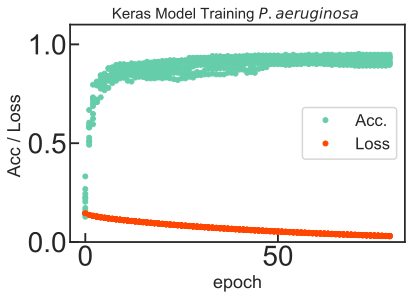

In [298]:
# Keras simulations using Matplotlib 

n_simulations = 10

train_acc = []
test_acc = []

for i in range(n_simulations):
    
    X_train, X_test, y_train, y_test = train_test_split(df_X, y_data
                                                        , test_size=0.25, random_state=42) 
    
    model = Sequential()
    model.add(Dense(units=500, activation='softmax', input_dim=n_components))
    model.add(Dense(units=8))# 8 cluster classif. output
    model.compile(loss= 'mse', optimizer='RMSprop', metrics= ['accuracy'])
    history = model.fit(X_train, y_train, epochs=80, batch_size= 60)

    accuracy = history.history['acc']
    loss = history.history['loss']
    train_acc.append(accuracy[79])
    
    score = model.evaluate(X_test, y_test,verbose=0)
    test_acc.append(score[1])

    # summarize history for accuracy/loss
    plt.plot(accuracy, 'o', color = 'mediumaquamarine', alpha = 0.3, markersize= 5)
    plt.plot(loss, 'o', color = 'orangered', alpha = 0.3, markersize= 5)
    plt.title('Keras Model Training $P. aeruginosa$ ', fontsize = 15)
    plt.ylabel('Acc / Loss ')
    plt.xlabel('epoch')
    plt.ylim(0,1.1)
    plt.legend(['Acc.','Loss' ], loc='best')
    
#plt.savefig('keras-model-train-paeru.tiff', dpi = 350)    

In [299]:
train = ['train'] * len(train_acc)
test = ['test'] * len(train_acc)

In [302]:
paeru = ['$P. aeruginosa$']* len(train_acc)

In [303]:
x = list(zip(train_acc, paeru,train))
y = list(zip(test_acc, paeru, test))

In [305]:
x[:5]

[(0.9320000076293945, '$P. aeruginosa$', 'train'),
 (0.9359999895095825, '$P. aeruginosa$', 'train'),
 (0.9120000123977661, '$P. aeruginosa$', 'train'),
 (0.9040000009536743, '$P. aeruginosa$', 'train'),
 (0.907999997138977, '$P. aeruginosa$', 'train')]

In [306]:
entries= x + y 

In [307]:
entries[:5]

[(0.9320000076293945, '$P. aeruginosa$', 'train'),
 (0.9359999895095825, '$P. aeruginosa$', 'train'),
 (0.9120000123977661, '$P. aeruginosa$', 'train'),
 (0.9040000009536743, '$P. aeruginosa$', 'train'),
 (0.907999997138977, '$P. aeruginosa$', 'train')]

In [308]:
paeru_df = pd.DataFrame(index = range(n_simulations*2))
paeru_df = pd.DataFrame(entries, columns=['accuracy', 'organism', 'type'])

(0.3, 1.1)

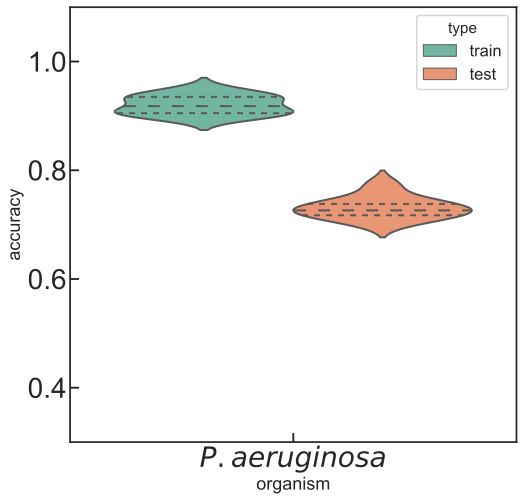

In [311]:
plt.figure(figsize = (8,8))
sns.violinplot(x = 'organism', y = 'accuracy',
               hue = 'type', data = paeru_df,
               palette = 'Set2', scale = 'width', 
              inner = 'quartile')

plt.ylim(.3, 1.1)



### MLP

In [251]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(1000, 20), random_state=42)

model.fit(X_train, y_train)  

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [252]:
y_pred= model.predict(X_test)

y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

In [253]:
print(classification_report(y_test, y_pred))
print('Accuracy score : ', accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.92      0.85        12
          1       0.90      0.64      0.75        14
          2       0.50      0.43      0.46         7
          3       0.73      0.79      0.76        14
          4       0.71      0.71      0.71         7
          5       1.00      0.33      0.50         6
          6       1.00      0.50      0.67         6
          7       1.00      0.40      0.57         5

avg / total       0.81      0.65      0.70        71

Accuracy score :  0.6567164179104478


In [254]:
results = cross_val_score(model, X_train, y_train, cv=5)
print("Mean cross validation score: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Mean cross validation score: 54.31% (1.74%)


Text(0.5,1,'MLP Confusion Matrix $P. aeruginosa $')

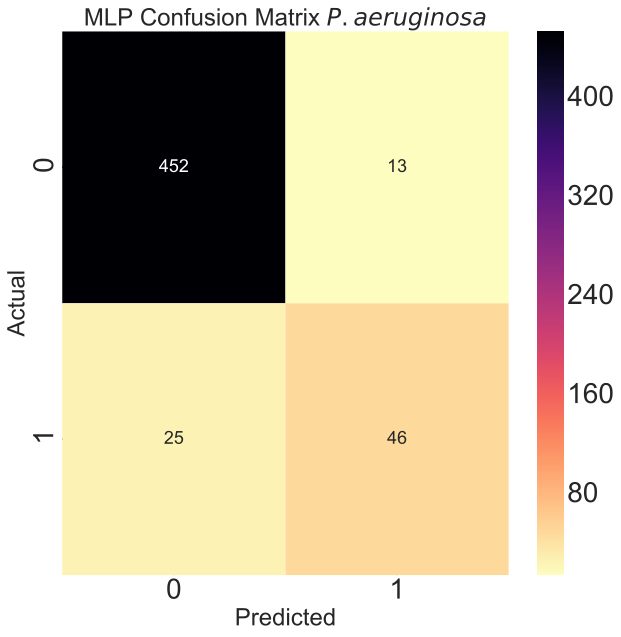

In [255]:
conf_mat = confusion_matrix(y_test_flat, y_pred_flat)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
           cmap = 'magma_r')
# xticklabels=['not in cluster', 'inside cluster'], yticklabels=['not in cluster', 'inside cluster'],

plt.ylabel('Actual', fontsize = 24)
plt.xlabel('Predicted', fontsize = 24)
plt.title('MLP Confusion Matrix $P. aeruginosa $', fontsize = 24)
#plt.savefig('conf-mat-paeru-mlp.tiff', dpi = 350)


In the case of *P. aeruginosa* the best model is MLP. One should further tune the hyperparameters for better results. Moreover, one further step is to do feature engineering on the expression conditions to get better prediction accuracy.